# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='./Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to the environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = "cpu"

# Implement multivariate Gaussian policy with fixed scale
class Policy(nn.Module):
    def __init__(self, state_size, action_size):
        super(Policy, self).__init__()

        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)

        # Create an output layer for the means
        self.mean = nn.Linear(64, action_size)

    def forward(self, state):
        x = F.tanh(self.fc1(state))
        x = F.tanh(self.fc2(x))

        mu = self.mean(x)        
        return mu, torch.zeros(action_size)
    
# Construct the policy model
policy = Policy(state_size, action_size).to(device)

# Use the Adam optimizer with learning rate 2.5e-4
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=2.5e-4)

### 5. PPO

Implement the PPO algorithm

In [6]:
from collections import deque
from torch.distributions import MultivariateNormal

num_epochs = 7

def sample_trajectory_segment(policy, env_info, horizon):
    """
    Sample a trajectory segment

    :param (Policy) policy
    :param (BrainInfo) env_info
    :param horizon (int) the number of timesteps to sample
    :return: (dict) generator with the following keys:
    
        - ob: (np.array) observations
        - ac: (np.array) actions
        - rew: (float) rewards
        - logprob: (np.array) log probabilities of actions
        - done: True if end of episode (one of more)
        - ep_rets: (float) cumulated current episode reward
        - ep_len: (int) the length of the current episode
        - total_timesteps: (int) number of timesteps across horizon
    """
    env_info = env.reset(train_mode=True)[brain_name]
    observation = np.asarray(env_info.vector_observations, dtype=np.float32)  # shape (20, 33)
    ob, ac, rew, logprob = [], [], [], []
    cur_ep_ret = 0  # return in current episode
    cur_ep_len = 0  # len of current episode
    ep_rets = []    # returns of completed episodes in this segment
    ep_lens = []    # lengths of completed episodes in this segment
    step = 0
    done = False

    while True:
        if step > 0 and step % horizon == 0:
            total_timesteps = sum(ep_lens) + cur_ep_len
            yield {"ob": ob, "ac": ac, "rew": rew, "logprob": logprob,
                   "done": done, "ep_rets": ep_rets, "ep_lens": ep_lens,
                   "total_timesteps": total_timesteps}
            ob, ac, rew, logprob = [], [], [], []
            ep_rets = []  # returns of completed episodes in this segment
            ep_lens = []  # lengths of completed episodes in this segment
            done = False

        ob.append(observation)

        # Get probability distribution associated with state
        with torch.no_grad():
            mean, log_std = policy(torch.from_numpy(observation))
            scale = torch.diag(torch.exp(log_std))
            m = MultivariateNormal(mean, scale_tril=scale)
            
            # Use the "reparameterization trick" to sample an action
            # for each agent:
            #     mu + sigma * z,         z ~ N(0, I)
            action = m.rsample()  # shape (20, 4)
            p = m.log_prob(action)
            action = action.numpy()
            ac.append(action)
            logprob.append(p.numpy())

        # Clip the action to avoid out of bounds error
        clipped_action = np.clip(action, -1, 1)
        
        # Take a step and get a reward
        env_info = env.step(clipped_action)[brain_name]
        rew.append(env_info.rewards)
        observation = np.asarray(env_info.vector_observations, dtype=np.float32)
        dones = env_info.local_done
        
        cur_ep_ret += sum(env_info.rewards)
        cur_ep_len += 1
        if np.any(dones):
            ep_rets.append(cur_ep_ret)
            ep_lens.append(cur_ep_len)
            cur_ep_ret = 0
            cur_ep_len = 0
            env_info = env.reset(train_mode=True)[brain_name]
            done = True
        step += 1

def discounted_rewards_to_go(rewards, discount):
    rewards = np.stack(rewards)  # shape (T, num_agents)
    T = rewards.shape[0]
    discounts = discount**np.arange(T).reshape(T, -1)
    discounted_rewards = rewards * discounts
        
    # Compute the "rewards to go" (future rewards) using reverse cumulative sum
    future_rewards = discounted_rewards[::-1,...].cumsum(axis=0)[::-1,...]
    return future_rewards.flatten()

def surrogate_loss(policy, obs, actions, adv, old_logp, epsilon, ent_coef):
    # Calculate log probabilities using current policy
    mean, log_std = policy(torch.from_numpy(obs))
    scale = torch.diag(torch.exp(log_std))
    m = MultivariateNormal(mean, scale_tril=scale)
    logp = m.log_prob(torch.from_numpy(actions))
    ent = m.entropy()
    ent_loss = torch.mean(ent) * ent_coef
    
    # Convert to torch tensors
    adv = torch.tensor(adv.squeeze(), dtype=torch.float32)
    
    # Ratio for clipping
    ratio = torch.exp(logp - torch.from_numpy(old_logp))

    # Compute the policy loss
    surr1 = ratio * adv
    surr2 = torch.clamp(ratio, 1.0 - epsilon, 1.0 + epsilon) * adv    
    policy_loss = torch.mean(torch.min(surr1, surr2))

    # Compute the total loss
    return policy_loss - ent_loss
    
def learn(max_timesteps, horizon, batch_size, discount=1.0, print_every=10, seed=5):
    total_episodes = 0
    total_timesteps = 0
    epsilon = 0.1
    ent_coef = 0.01
    
    torch.manual_seed(seed)

    # Multiplier for annealing clipping param
    mult = max(1.0 - float(total_timesteps) / max_timesteps, 0.0)

    # Sample from the old policy
    seg_gen = sample_trajectory_segment(policy, env_info, horizon)
    
    # Keep track of the mean rewards across the agents per episode
    mean_rewards = []
    
    # Rolling buffer for episode rewards
    rewards_buffer = deque(maxlen=100)

    while True:
        if total_timesteps >= max_timesteps:
            break

        # Get the next trajectory segment
        seg = seg_gen.__next__()        
        obs = np.concatenate(seg["ob"])
        actions = np.concatenate(seg["ac"])
        old_logprob = np.concatenate(seg["logprob"])
        rewards = seg["rew"]
        
        # Compute discounted future rewards
        adv = discounted_rewards_to_go(rewards, discount)
        adv = np.expand_dims(adv, axis=1)
        
        # Normalize the advantages. This lowers variance
        adv = (adv - adv.mean()) / (adv.std() + 1e-10)
            
        # Process each epoch in mini batches. Shuffle between epochs
        indices = np.arange(obs.shape[0])
        assert(indices.shape[0] % batch_size == 0)
        num_batches = indices.shape[0] // batch_size
        for e in range(num_epochs):
            for i in range(num_batches):
                start_index = i*batch_size
                end_index = start_index + batch_size
                loss = -surrogate_loss(policy,
                                       obs[start_index:end_index, :],
                                       actions[start_index:end_index, :],
                                       adv[start_index:end_index, :],
                                       old_logprob[start_index:end_index],
                                       epsilon,
                                       ent_coef)            
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            # Shuffle
            np.random.shuffle(indices)
            obs = obs[indices,:]
            actions = actions[indices,:]
            adv = adv[indices, :]
            old_logprob = old_logprob[indices]

        # See if we completed an episode
        if seg["done"]:
            total_episodes += 1
            total_timesteps += seg["total_timesteps"]
            ep_rets = seg["ep_rets"]
            avg_reward = ep_rets[0] / num_agents
            mean_rewards.append(avg_reward)
            rewards_buffer.append(avg_reward)
            
            # Anneal clipping parameter
            epsilon *= mult
            # Reduce regularization term also reduces (less exploration in later runs)
            ent_coef *= 0.995

            # Print status as requested
            if total_episodes % print_every == 0:
                ep_lens = seg["ep_lens"]
                print("Episode length is {}, average reward is {}, total timesteps is {}" \
                    .format(ep_lens[0], avg_reward, total_timesteps))
                
            if np.mean(rewards_buffer) >= 30.0:
                print("\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}" \
                      .format(total_episodes - 100, np.mean(rewards_buffer)))
                # Save the model
                torch.save(policy.state_dict(), 'checkpoint.pth')
                break
            
    return mean_rewards
    
scores = learn(max_timesteps=600000, horizon=120, batch_size=800, discount=0.99, print_every=5)

Episode length is 1001, average reward is 1.6519999630749225, total timesteps is 5350
Episode length is 1001, average reward is 2.3404999476857484, total timesteps is 10755
Episode length is 1001, average reward is 4.1464999073185025, total timesteps is 16095
Episode length is 1001, average reward is 4.467999900132417, total timesteps is 21370
Episode length is 1001, average reward is 5.8414998694323, total timesteps is 26700
Episode length is 1001, average reward is 5.8704998687840995, total timesteps is 31965
Episode length is 1001, average reward is 7.033499842789024, total timesteps is 37165
Episode length is 1001, average reward is 8.202499816659838, total timesteps is 42420
Episode length is 1001, average reward is 8.046999820135534, total timesteps is 47850
Episode length is 1001, average reward is 9.182999794743955, total timesteps is 53215
Episode length is 1001, average reward is 10.376999768055976, total timesteps is 58515
Episode length is 1001, average reward is 10.9859997

### 6. Plot the rewards

Plot the training progress over time

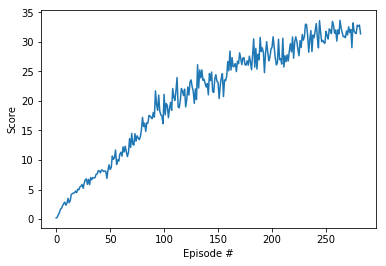

In [7]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
fig.savefig('training.pdf', bbox_inches='tight')

### 7. Play an episode

In [8]:
env_info = env.reset(train_mode=False)[brain_name]
observation = np.asarray(env_info.vector_observations, dtype=np.float32)
while True:
    with torch.no_grad():
        actions, _ = policy(torch.from_numpy(observation))
        actions = torch.clamp(actions, -1, 1).numpy()
    env_info = env.step(actions)[brain_name]           # send all actions to the environment
    observation = np.asarray(env_info.vector_observations, dtype=np.float32)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    if np.any(dones):                                  # exit loop if episode finished
        break

In [9]:
env.close()